IMPORTANT: the notebook's native use is in Colab environment since we use bash commands for installing libraries and other packages. For this reason if you want to run you can open the link from here:


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rjSa60Cg39QO-Bd4BAj7VlGlnvY6tF_Q?authuser=1#scrollTo=TVIkG9ifK6HG&uniqifier=1)

Installing needed packages...

In [1]:
%%capture
!pip install jsonlines
!pip install jinja2

Importing needed libraries...

In [2]:
import pandas as pd
from google.colab import drive
import jsonlines
import json
import jinja2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os

Downloading the dataset EmoITA in development and test

In [3]:
#download the dataset using wget

!wget -O EmotivITA_Development.csv "https://github.com/GiovanniGafa/EmoITA/raw/main/EmotivITA/Development%20set.csv"
!wget -O EmotivITA_Test.csv "https://github.com/GiovanniGafa/EmoITA/raw/main/EmotivITA/Test%20set%20-%20Gold%20labels.csv"

--2024-04-07 09:22:38--  https://github.com/GiovanniGafa/EmoITA/raw/main/EmotivITA/Development%20set.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GiovanniGafa/EmoITA/main/EmotivITA/Development%20set.csv [following]
--2024-04-07 09:22:38--  https://raw.githubusercontent.com/GiovanniGafa/EmoITA/main/EmotivITA/Development%20set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989832 (967K) [text/plain]
Saving to: ‘EmotivITA_Development.csv’

EmotivITA_Developme 100%[===================>] 966.63K  --.-KB/s    in 0.05s   

2024-04-07 09:22:38 (18.9 MB/s) - ‘EmotivITA_Development.csv’ saved 

Reading .csv and transforming in pandas Dataframe data structure

In [4]:
df_dev = pd.read_csv("EmotivITA_Development.csv", delimiter=',')
df_test = pd.read_csv("EmotivITA_Test.csv", delimiter=',')

Setting the seed for enforcing repeatability

In [5]:
random.seed(42)

Code for data distributions analysis.

We obtain thresholds from 0.33 and 0.67 percentiles in order to later discretize continous values on dimensions columns in three hopefully balanced classes.

Note that I proceed to do the analysis separetely on test and development sets, they have very similar thresholds but to ensure that the discretization is coherent between datasets I take the mean of each threshold from test and development, this to mitigate as much as possible biases introducing different thresholds for the datasets.

About distribution, as commented in the report, all three dimensions follow a Gaussian-like distribution.

Column: A
Thresholds per il DataFrame 1: [3.5, 3.92]
Thresholds per il DataFrame 2: [3.5, 3.92]
Thresholds combinati: [3.5, 3.92]


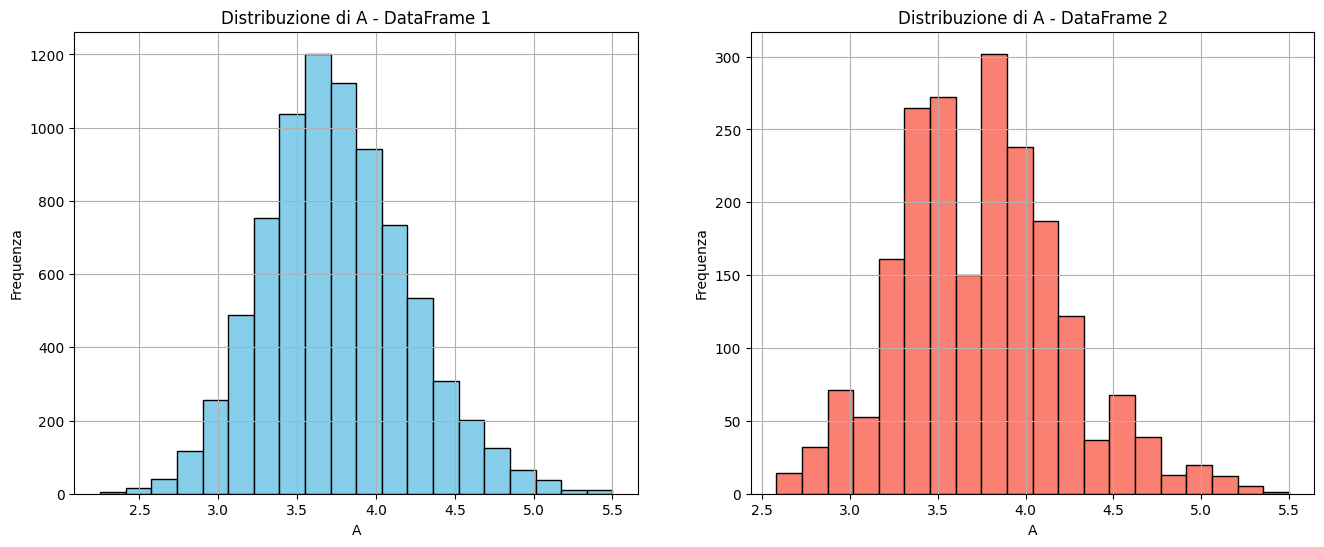

Column: V
Thresholds per il DataFrame 1: [3.33, 3.75]
Thresholds per il DataFrame 2: [3.33, 3.75]
Thresholds combinati: [3.33, 3.75]


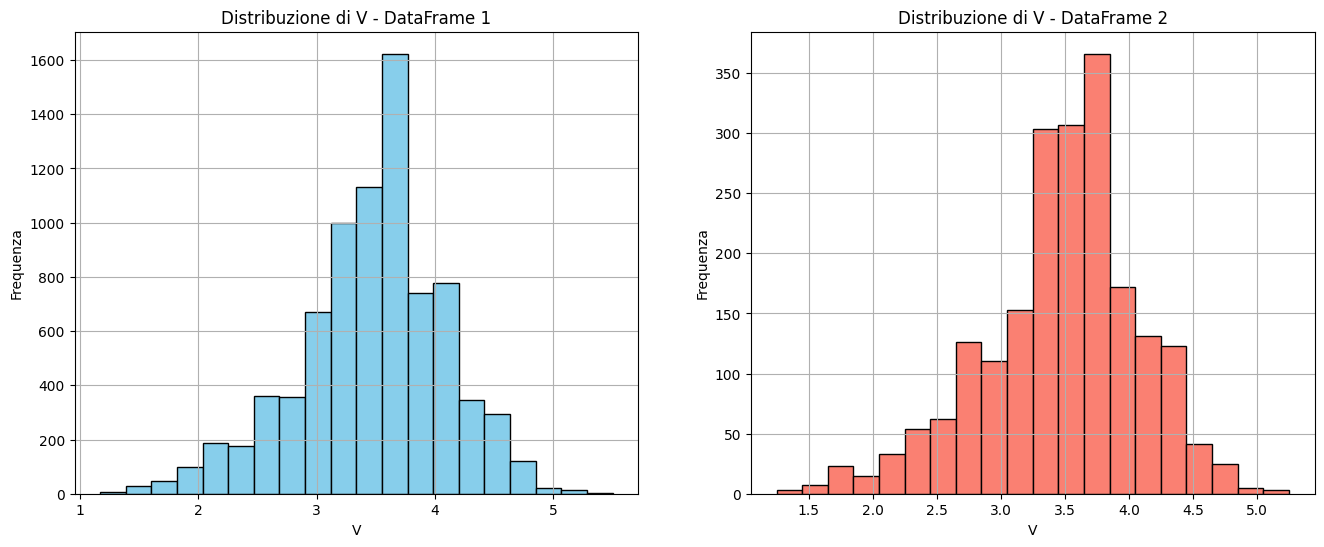

Column: D
Thresholds per il DataFrame 1: [3.25, 3.6096999999999935]
Thresholds per il DataFrame 2: [3.33, 3.67]
Thresholds combinati: [3.29, 3.6398499999999965]


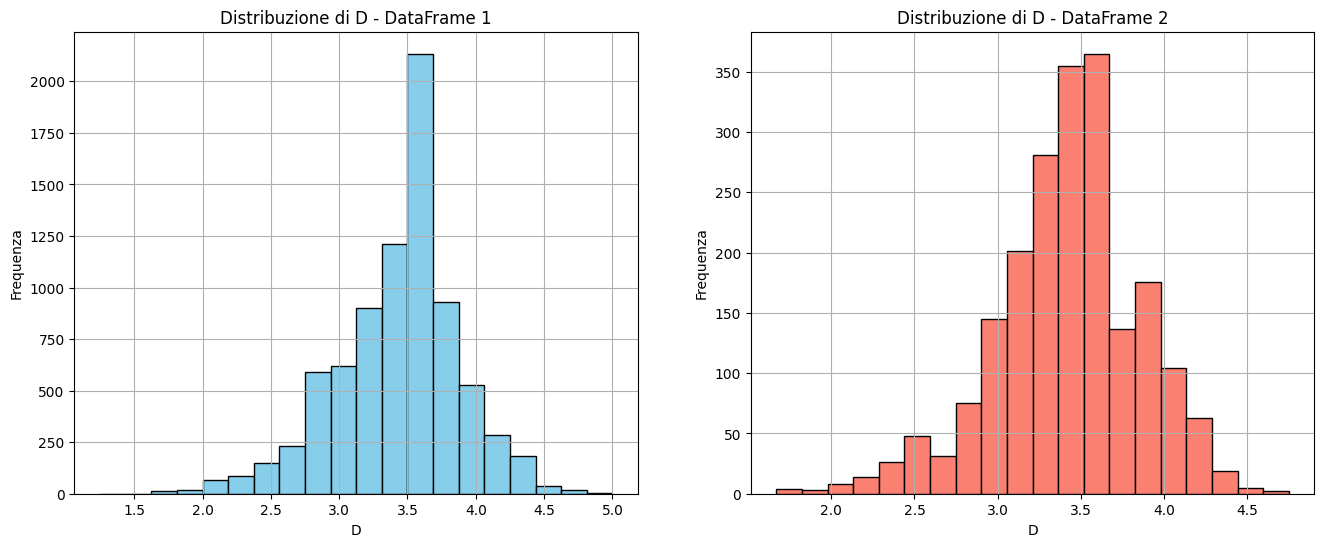

In [6]:
def plot_distribution(dataframe1, dataframe2, column_name):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].hist(dataframe1[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title(f'Distribuzione di {column_name} - DataFrame 1')
    axs[0].set_xlabel(column_name)
    axs[0].set_ylabel('Frequenza')
    axs[0].grid(True)

    axs[1].hist(dataframe2[column_name], bins=20, color='salmon', edgecolor='black')
    axs[1].set_title(f'Distribuzione di {column_name} - DataFrame 2')
    axs[1].set_xlabel(column_name)
    axs[1].set_ylabel('Frequenza')
    axs[1].grid(True)

    plt.show()

def calculate_and_print_quantiles(dataframe1, dataframe2, column_name):
    print("Column:", column_name)

    # Calcola i quantili per il primo dataframe
    quartiles_df1 = dataframe1[column_name].quantile([0.33, 0.67])
    thresholds_df1 = quartiles_df1.values.tolist()
    print("Thresholds per il DataFrame 1:", thresholds_df1)

    # Calcola i quantili per il secondo dataframe
    quartiles_df2 = dataframe2[column_name].quantile([0.33, 0.67])
    thresholds_df2 = quartiles_df2.values.tolist()
    print("Thresholds per il DataFrame 2:", thresholds_df2)

    # Calcola le soglie definitive come media tra i valori dei quartili dei due dataframe
    thresholds_combined = [(thresholds_df1[0] + thresholds_df2[0]) / 2, (thresholds_df1[1] + thresholds_df2[1]) / 2]
    print("Thresholds combinati:", thresholds_combined)

    # Plotta la distribuzione per entrambi i dataframe
    plot_distribution(dataframe1, dataframe2, column_name)

    return thresholds_combined

thresholds_A = calculate_and_print_quantiles(df_dev, df_test, 'A')
thresholds_V = calculate_and_print_quantiles(df_dev, df_test, 'V')
thresholds_D = calculate_and_print_quantiles(df_dev, df_test, 'D')

There are some samples that have more than 5 as values in the dimension.

In [ ]:
max_A = df_dev['A'].max()
max_V = df_dev['V'].max()
max_D = df_dev['D'].max()

print("Maximum value in column A:", max_A)
print("Maximum value in column V:", max_V)
print("Maximum value in column D:", max_D)

Maximum value in column A: 5.5
Maximum value in column V: 5.5
Maximum value in column D: 5.0


Some examples of these samples:

In [17]:
df_dev[df_dev['A']>5.0][0:3]

,id,text,V,A,D
216,217,"""Oh, merda!""",2.08,5.50,1.75
332,333,Un legislatore curdo ucciso in un attacco a Ba...,1.58,5.33,2.50
796,797,L'epidemia di influenza aviaria russa è un cep...,2.08,5.33,2.67


Code for discretization through thresholds obtained before

In [10]:
def discretize_column(value, thresholds):
    if value < thresholds[0]:
        return "bassa"
    elif thresholds[0] <= value < thresholds[1]:
        return "media"
    else:
        return "alta"

def modify_dataset_with_thresholds(df, thresholds_A, thresholds_V, thresholds_D):
    # Crea una nuova istanza del dataframe da modificare
    discretized_df = df.copy()

    discretized_df['id'] = range(0, len(df))

    # Discretizza il dataframe utilizzando le soglie specifiche
    discretized_df['A'] = discretized_df['A'].apply(discretize_column, thresholds=thresholds_A)
    discretized_df['V'] = discretized_df['V'].apply(discretize_column, thresholds=thresholds_V)
    discretized_df['D'] = discretized_df['D'].apply(discretize_column, thresholds=thresholds_D)

    discretized_df.rename(columns = {'A':'eccitazione', 'V':'positività', 'D':'dominanza'}, inplace = True)

    return discretized_df

discretized_dev_df = modify_dataset_with_thresholds(df_dev,thresholds_A, thresholds_V, thresholds_D)
discretized_test_df = modify_dataset_with_thresholds(df_test,thresholds_A, thresholds_V, thresholds_D)


Function to plot the distribution of classes after the discretization for each dimension

In [11]:
def check_distributions(discretized_df):
  # Creazione dei subplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot per la dominanza
  discretized_df.groupby('dominanza').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[0])
  axes[0].set_title('Dominanza')
  axes[0].spines[['top', 'right']].set_visible(True)

  # Plot per l'eccitazione
  discretized_df.groupby('eccitazione').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[1])
  axes[1].set_title('Eccitazione')
  axes[1].spines[['top', 'right']].set_visible(True)

  # Plot per la valenza
  discretized_df.groupby('positività').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[2])
  axes[2].set_title('Positività')
  axes[2].spines[['top', 'right']].set_visible(True)

  # Regolazione dello spazio tra i subplots
  plt.tight_layout()

  # Mostra il grafico
  plt.show()

In [12]:
discretized_dev_df

,id,text,positività,eccitazione,dominanza
0,0,Auguriamo a voi e alla vostra famiglia un nuov...,alta,bassa,alta
1,1,Ha anche respinto le notizie secondo cui le su...,bassa,bassa,media
2,2,27 aprile 2009 12:07 Padraic Ryan: Oggetto: re...,bassa,alta,bassa
3,3,I drastici cambi di tempo e metro e le prime a...,media,media,bassa
4,4,Stiamo aiutando a sviluppare,alta,media,alta
...,...,...,...,...,...
7995,7995,Non dimenticare che è la tua ragazza.,media,alta,alta
7996,7996,"Frank Sinatra, Wayne Newton e Louis Prima arri...",alta,alta,alta
7997,7997,Riferimenti,media,bassa,bassa
7998,7998,Il maltempo annulla la discesa libera maschile.,bassa,media,bassa


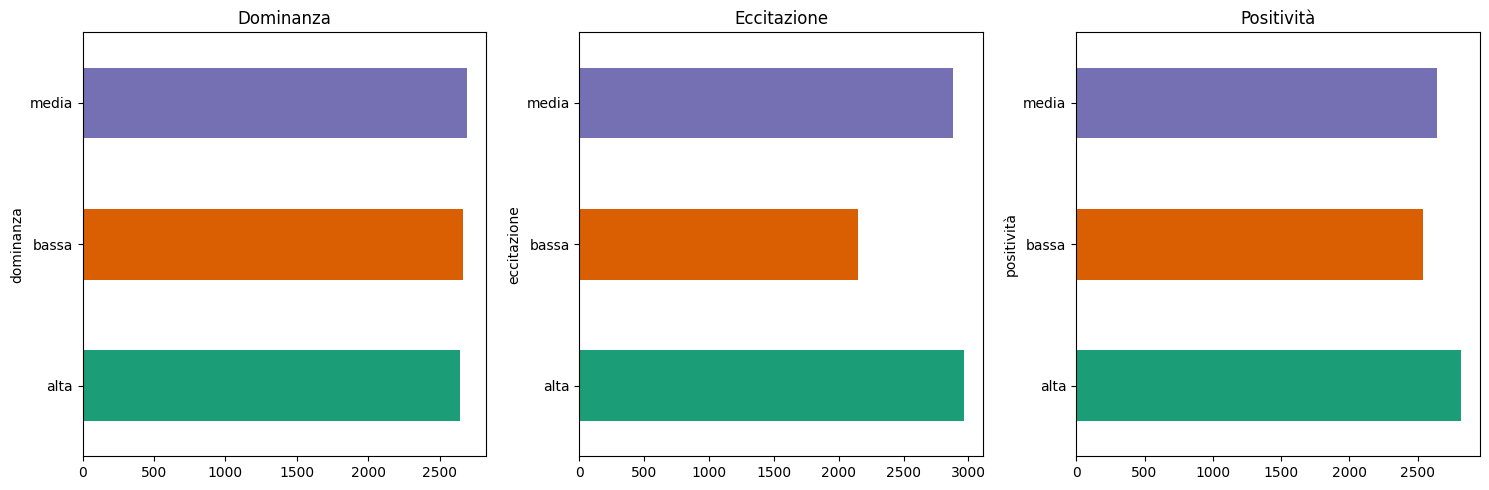

In [13]:
check_distributions(discretized_dev_df)

In [14]:
discretized_test_df

,id,text,positività,eccitazione,dominanza
0,0,È vero che il film di Moore a volte è involont...,bassa,media,bassa
1,1,Influenza aviaria letale confermata nei tacchi...,bassa,alta,bassa
2,2,Sarti e casalinghe occupati mentre i musulmani...,alta,media,alta
3,3,"Poiché siete un'organizzazione che ci tiene, s...",alta,alta,alta
4,4,I sandinisti Thomas Borge e i fratelli Ortega ...,bassa,alta,bassa
...,...,...,...,...,...
2057,2057,"La leggenda cinese di Madame Serpe Bianca, il ...",alta,media,media
2058,2058,"Ma soprattutto, mi chiedo cosa succederà quand...",media,alta,bassa
2059,2059,Shenzhen è stata la prima Zona Economica Speci...,alta,media,media
2060,2060,"Grazie, Artù.",alta,media,media


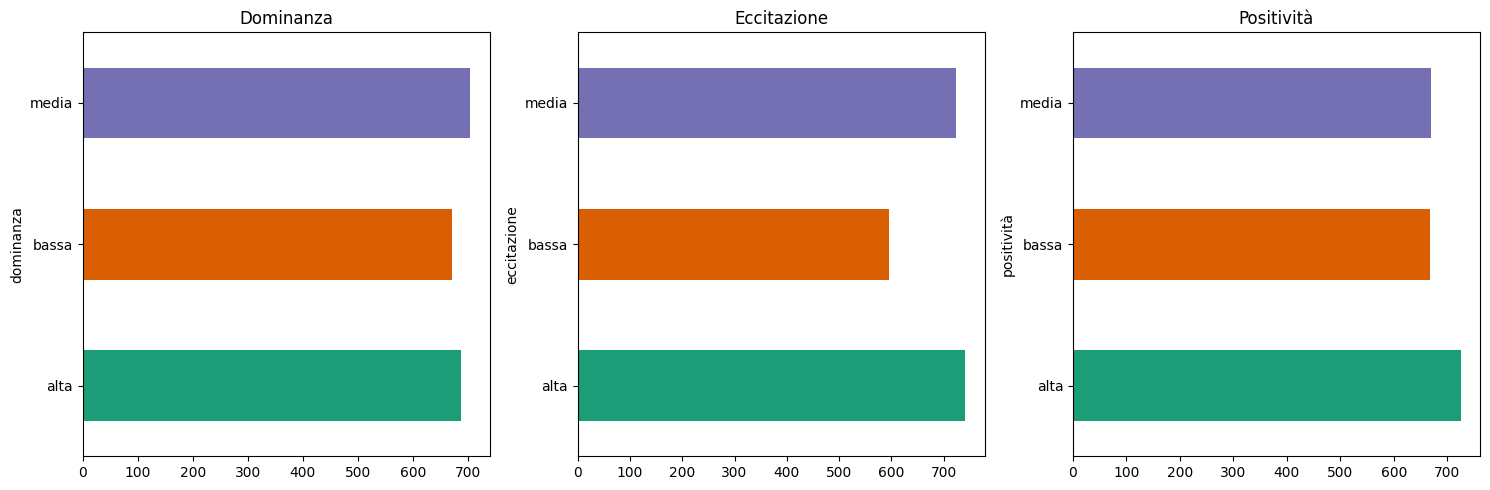

In [15]:
check_distributions(discretized_test_df)

We see that each dimension is quite balanced. The "eccitazione" one is a little imbalanced so it's more challenging and is due to the diversity of data between test and developmen which was mitigated by taking the average between thresholds of test and dev. -> note that we could have chosen two different values of thresholds depending on the dataframe but we would have "corrected" a distribution which is inherently different.

In [ ]:
def create_json(discretized_df, json_name, dimension):
  # Iterate over each row in the DataFrame and write JSONL format
  name = json_name[:json_name.index('.jsonl')]
  with jsonlines.open(json_name, 'w') as writer:
      for index, row in discretized_df.iterrows():
          writer.write(row_to_json(row,dimension,name))

def row_to_json(row, dimension, name):
    choices = ["bassa", "media", "alta"]
    solution = row[dimension]
    random.shuffle(choices)
    label = choices.index(solution)

    data = {
        "id": f"{name}-{row['id']}",
        "text": row['text'],
        "dimension": dimension,
        "choices": choices,
        "label": label
    }
    return data


# List of dimensions
dimensions_ita = ["positività", "eccitazione", "dominanza"]
dimensions_eng = ["Valence", "Arousal", "Dominance"]

# Iterate over each dimension and call create_json function with appropriate filenames
for i in range(len(dimensions_ita)):
    create_json(discretized_dev_df, f'EmotivITA_{dimensions_eng[i]}_dev.jsonl', dimensions_ita[i])
    create_json(discretized_test_df, f'EmotivITA_{dimensions_eng[i]}_test.jsonl', dimensions_ita[i])


To verify that the json is in fact correct!

In [ ]:
prompts_list = ["Considerando il seguente testo: \"{{text}}\", quale valore di {{dimension}} assegneresti tra le opzioni seguenti: {{choices}}?",
                "Esaminando il testo: \"{{text}}\", qual è, secondo te, il valore di {{dimension}} tra le seguenti opzioni: {{choices}}?",
                "Valuta la {{dimension}} del testo riportato di seguito: \"{{text}}\". Scegli uno dei seguenti valori: {{choices}}.",
                "Esamina il testo qui di seguito: \"{{text}}\". Qual è il valore appropriato da attribuire alla {{dimension}} tra le seguenti opzioni: {{choices}}?"]

In [ ]:
with jsonlines.open('EmotivITA_prompts.jsonl', 'w') as writer:
  for prompt in prompts_list:
    data = {"prompt": prompt}
    writer.write(data)

Code for veryfing correctness of .jsonl files produced. Populating prompt templates.

In [ ]:
def verify_correctness(file_path, num_samples, prompts_list):
  # Read the JSONL file line by line
  env = jinja2.Environment()
  with open(file_path, 'r') as f:
      i = 0
      for line in f:
          if i >= num_samples:
              break

          # Parse JSON from each line
          data = json.loads(line)

          # Iterate over the prompts list
          for prompt in prompts_list:
              template = env.from_string(prompt)
              # Replace placeholders with data values
              filled_prompt = template.render(text=data['text'],
                                            dimension=data['dimension'],
                                            choices=', '.join(data['choices']))
              print(i,filled_prompt)
              print("LABEL:", data['choices'][int(data['label'])])
          i+=1

verify_correctness('EmotivITA_Valence_dev.jsonl',2, prompts_list)


0 Considerando il seguente testo: "Auguriamo a voi e alla vostra famiglia un nuovo anno pieno di gioia e amore.", quale valore di positività assegneresti tra le opzioni seguenti: media, bassa, alta?
LABEL: alta
0 Esaminando il testo: "Auguriamo a voi e alla vostra famiglia un nuovo anno pieno di gioia e amore.", qual è, secondo te, il valore di positività tra le seguenti opzioni: media, bassa, alta?
LABEL: alta
0 Valuta la positività del testo riportato di seguito: "Auguriamo a voi e alla vostra famiglia un nuovo anno pieno di gioia e amore.". Scegli uno dei seguenti valori: media, bassa, alta.
LABEL: alta
0 Esamina il testo qui di seguito: "Auguriamo a voi e alla vostra famiglia un nuovo anno pieno di gioia e amore.". Qual è il valore appropriato da attribuire alla positività tra le seguenti opzioni: media, bassa, alta?
LABEL: alta
1 Considerando il seguente testo: "Ha anche respinto le notizie secondo cui le sue dimissioni derivavano dalla delusione che il posto di direttore generale